<a href="https://colab.research.google.com/github/hmezer/eam-double-response/blob/main/data_exploration-v202507142050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/hmezer/eam-double-response

Cloning into 'eam-double-response'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 62 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 4.79 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('eam-double-response/data/db-data.txt', sep=" ")
df.head()

,subj,block,trialnr,stim,wnw,freq,resp,RT,correct
0,S1,1,1,schork,2,0,1,663.8,0
1,S1,1,2,smeris,1,"5,341176471",1,564.7,1
2,S1,1,3,jargon,1,"4,094117647",1,684.2,1
3,S1,1,4,getij,1,"3,976470588",1,642.7,1
4,S1,1,5,zindig,2,0,2,866.3,1


In [ ]:
df[df['RT'] <= 250].shape

(167, 9)

In [ ]:
print("=== ORIGINAL DATA EXAMINATION FOR DOUBLE RESPONSES ===")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check if there might be consecutive responses within 250ms
def detect_potential_double_responses(df):
    """
    Detect potential double responses in the original data based on Evans et al. (2020) definition:
    A second response for the opposite alternative occurring within 250 ms of the initial response
    """
    print("\n🔍 SEARCHING FOR DOUBLE RESPONSE PATTERNS...")

    # Sort by subject, block, and trial number
    df_sorted = df.sort_values(['subj', 'block', 'trialnr']).reset_index(drop=True)

    double_responses = []

    for i in range(len(df_sorted) - 1):
        current_trial = df_sorted.iloc[i]
        next_trial = df_sorted.iloc[i + 1]

        # Check if same subject and block, consecutive trials
        if (current_trial['subj'] == next_trial['subj'] and
            current_trial['block'] == next_trial['block'] and
            next_trial['trialnr'] == current_trial['trialnr'] + 1):

            # Calculate time difference (assuming trials are close in time)
            # Check if responses are opposite and next trial is very fast (<250ms from previous)
            if (current_trial['resp'] != next_trial['resp'] and
                next_trial['RT'] < 250):  # Very fast response suggesting correction

                double_responses.append({
                    'subj': current_trial['subj'],
                    'block': current_trial['block'],
                    'trial1': current_trial['trialnr'],
                    'trial2': next_trial['trialnr'],
                    'resp1': current_trial['resp'],
                    'resp2': next_trial['resp'],
                    'rt1': current_trial['RT'],
                    'rt2': next_trial['RT'],
                    'correct1': current_trial['correct'],
                    'correct2': next_trial['correct']
                })

    print(f"Potential double response patterns found: {len(double_responses)}")

    if len(double_responses) > 0:
        dr_df = pd.DataFrame(double_responses)
        print("Sample patterns:")
        print(dr_df.head())
        return dr_df
    else:
        print("❌ No clear double response patterns detected in consecutive trials")
        print("💡 This suggests the dataset contains only single responses per trial")
        return None

# Look for double response patterns
potential_dr = detect_potential_double_responses(df)

# Analyze RT distribution for very fast responses that might indicate corrections
very_fast = df[df['RT'] < 250]
print(f"\n📊 Very fast responses (<250ms): {len(very_fast)} ({len(very_fast)/len(df)*100:.2f}%)")

if len(very_fast) > 0:
    print(f"Mean RT of very fast responses: {very_fast['RT'].mean():.1f}ms")
    print(f"Accuracy of very fast responses: {very_fast['correct'].mean():.3f}")

=== ORIGINAL DATA EXAMINATION FOR DOUBLE RESPONSES ===
Dataset shape: (40000, 9)
Columns: ['subj', 'block', 'trialnr', 'stim', 'wnw', 'freq', 'resp', 'RT', 'correct']

🔍 SEARCHING FOR DOUBLE RESPONSE PATTERNS...
Potential double response patterns found: 94
Sample patterns:
  subj  block  trial1  trial2  resp1  resp2    rt1   rt2  correct1  correct2
0   S1      1     109     110      2      1  582.0  37.8         0         1
1   S1      2      70      71      2      1  601.0  42.5         0         1
2   S1      2     288     289      2      1  471.5  19.7         0         0
3   S1      3      98      99      2      1  489.5  32.5         0         1
4   S1      5     193     194      2      1  463.7  33.2         0         1

📊 Very fast responses (<250ms): 167 (0.42%)
Mean RT of very fast responses: 144.1ms
Accuracy of very fast responses: 0.467


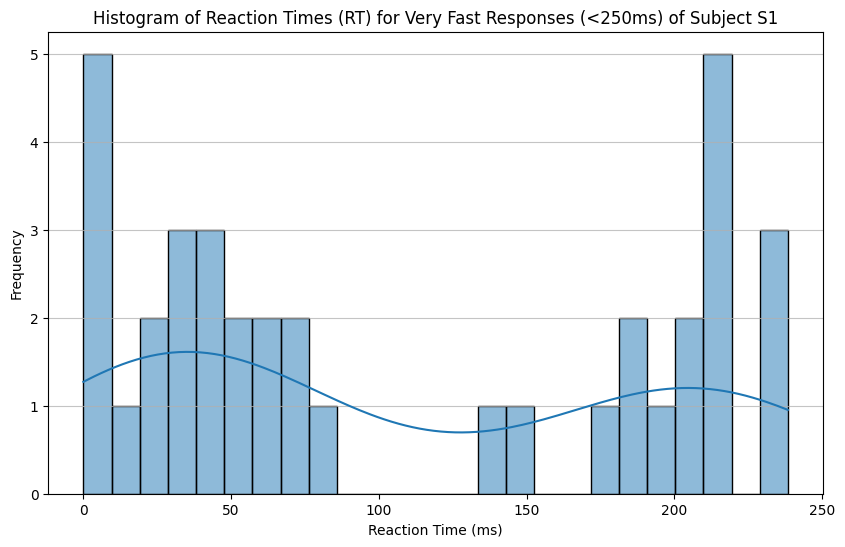

In [ ]:
# prompt: plot the histogram of RT from very_fast dataset for subj = 'S1'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter very_fast DataFrame for subject 'S1'
df_fast = df[df['RT'] <= 250]
very_fast_s1 = df_fast[df_fast['subj'] == 'S1']

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(very_fast_s1['RT'], kde=True, bins=25)
plt.title('Histogram of Reaction Times (RT) for Very Fast Responses (<250ms) of Subject S1')
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [19]:
# prompt: for each row that has RT < 250 and if the response is different than the row above, add two columns to the row one above this row, set dr_rt as the RT of the original row, and set dr_if to 1. and delete the original row. set the value of the dr_if to 0 for all the remaining rows. delete all the rows having RT < 250 after

import numpy as np
# Re-ensure the dataframe is sorted by subject, block, and trial number
df_processed = df.sort_values(['subj', 'block', 'trialnr']).reset_index(drop=True)

# Initialize the new columns
df_processed['dr_rt'] = np.nan
df_processed['dr_if'] = 0

# Identify rows with RT <= 250
rows_with_fast_rt = df_processed[df_processed['RT'] <= 250].index.tolist()

# Create a list to store the indices of rows to drop
rows_to_drop = []

# Iterate through the identified rows with fast RT
for idx in rows_with_fast_rt:
    # Ensure there is a row above
    if idx > 0:
        prev_row_idx = idx - 1

        # Check if the row above belongs to the same subject and block, is the previous trial,
        # and has a different response
        if (df_processed.loc[idx, 'subj'] == df_processed.loc[prev_row_idx, 'subj'] and
            df_processed.loc[idx, 'block'] == df_processed.loc[prev_row_idx, 'block'] and
            df_processed.loc[idx, 'trialnr'] == df_processed.loc[prev_row_idx, 'trialnr'] + 1 and
            df_processed.loc[idx, 'resp'] != df_processed.loc[prev_row_idx, 'resp']):

            # Add dr_rt and set dr_if to 1 for the row above
            df_processed.loc[prev_row_idx, 'dr_rt'] = df_processed.loc[idx, 'RT']
            df_processed.loc[prev_row_idx, 'dr_if'] = 1

            # Mark the current row (with RT <= 250 and meeting criteria) for deletion
            rows_to_drop.append(idx)

# Drop the identified rows (those with RT <= 250 that were part of a double response pattern)
df_processed = df_processed.drop(rows_to_drop).reset_index(drop=True)

# Now, delete all remaining rows where RT <= 250
df_processed = df_processed[df_processed['RT'] > 250].reset_index(drop=True)

print("\n=== FINAL DATASET AFTER REMOVING FAST RT ROWS ===")
print(f"Dataset shape: {df_processed.shape}")
print(f"Columns: {list(df_processed.columns)}")
print("\nSample rows with potential double responses handled (dr_if == 1):")
print(df_processed[df_processed['dr_if'] == 1].head())
print("\nSample rows without double responses (dr_if == 0):")
print(df_processed[df_processed['dr_if'] == 0].head())



=== FINAL DATASET AFTER REMOVING FAST RT ROWS ===
Dataset shape: (39833, 11)
Columns: ['subj', 'block', 'trialnr', 'stim', 'wnw', 'freq', 'resp', 'RT', 'correct', 'dr_rt', 'dr_if']

Sample rows with potential double responses handled (dr_if == 1):
      subj  block  trialnr    stim  wnw         freq  resp     RT  correct  \
20104   S1      1      109  lappen    1  4,305882353     2  582.0        0   
20463   S1      2       70   korps    1  3,741176471     2  601.0        0   
20680   S1      2      288    bres    1  3,952941176     2  471.5        0   
20889   S1      3       98    pion    1  2,117647059     2  489.5        0   
21783   S1      5      193  kastje    1  3,858823529     2  463.7        0   

       dr_rt  dr_if  
20104   37.8      1  
20463   42.5      1  
20680   19.7      1  
20889   32.5      1  
21783   33.2      1  

Sample rows without double responses (dr_if == 0):
  subj  block  trialnr    stim  wnw         freq  resp      RT  correct  \
0   A1      1        1 

In [20]:
df_processed[df_processed['dr_if'] == 1].shape

(91, 11)

In [21]:
# prompt: export df_processed to a txt file with sep=' '

df_processed.to_csv('df_processed.txt', sep=' ', index=False)